## Sources:

- Kaggle datasets: [link to datasets](https://www.kaggle.com/datasets/harrywang/propensity-score-matching?select=employment.csv)

- [Kaggle submission](https://www.kaggle.com/code/harrywang/propensity-score-matching-in-python)

- [PSMPY library article on Medium](https://towardsdatascience.com/psmpy-propensity-score-matching-in-python-a3e0cd4d2631)

- [Propensity Score Matching on Smokers dataset - Medium article](https://towardsdatascience.com/a-hands-on-introduction-to-propensity-score-use-for-beginners-856302b632ac)

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

## Groupon Dataset

- deal_id: the ID of the deal
- start_date: the starting date of the deal
- min_req: minimal number of orders for the deal to work
- treatment: 1 if has min_req, 0 otherwise
- prom_length: the length of the deal
- price: unit price of the item
- discount_pct: discount percentage
- coupon_duration: coupon duration
- featured: whether the deal is featured or not
- limited_supply: whether the supply of the item is limited or not
- fb_likes: Facebook likes received
- quantity_sold: quantity sold
- revenue: revenue of the deal

In [2]:
gpn_df = pd.read_csv('groupon.csv')
gpn_df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500


In [4]:
gpn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deal_id          710 non-null    object
 1   start_date       710 non-null    object
 2   min_req          710 non-null    int64 
 3   treatment        710 non-null    int64 
 4   prom_length      710 non-null    int64 
 5   price            710 non-null    int64 
 6   discount_pct     710 non-null    int64 
 7   coupon_duration  710 non-null    int64 
 8   featured         710 non-null    int64 
 9   limited_supply   710 non-null    int64 
 10  fb_likes         710 non-null    int64 
 11  quantity_sold    710 non-null    int64 
 12  revenue          710 non-null    int64 
dtypes: int64(11), object(2)
memory usage: 72.2+ KB


No missing data. Only deal_id and start_date are categorical.

In [5]:
gpn_df.describe().T

,count,mean,std,min,25%,50%,75%,max
min_req,710.0,8.759155,27.880963,1.0,1.0,1.0,5.0,300.0
treatment,710.0,0.304225,0.460403,0.0,0.0,0.0,1.0,1.0
prom_length,710.0,3.678873,1.323959,2.0,3.0,3.0,4.0,9.0
price,710.0,35.300000,36.356624,5.0,15.0,24.0,39.0,299.0
discount_pct,710.0,53.061972,8.190716,0.0,50.0,51.0,56.0,85.0
coupon_duration,710.0,106.863380,128.155130,0.0,11.0,75.0,185.0,1812.0
featured,710.0,0.116901,0.321529,0.0,0.0,0.0,0.0,1.0
limited_supply,710.0,0.829577,0.376269,0.0,1.0,1.0,1.0,1.0
fb_likes,710.0,88.669014,150.282551,0.0,17.0,40.5,99.0,1596.0
quantity_sold,710.0,386.652113,663.358446,0.0,70.0,190.0,480.0,5000.0


In [8]:
print (gpn_df.treatment.value_counts())
print('----------------')
gpn_df.treatment.value_counts(normalize= True)

0    494
1    216
Name: treatment, dtype: int64
----------------


0    0.695775
1    0.304225
Name: treatment, dtype: float64

Look at different start dates

In [9]:
gpn_df.start_date.nunique()

195

In [20]:
# gpn_df.start_date.sample(15)
gpn_df.start_date.value_counts()

2/2/2012      11
7/30/2012     10
2/9/2012      10
6/27/2012     10
2/7/2012       9
              ..
1/24/2012      1
2/10/2012      1
5/26/2012      1
11/24/2011     1
2/3/2012       1
Name: start_date, Length: 195, dtype: int64

In [19]:
# data is mostly from 2012, some from 2011
gpn_df.start_date.str[-4:].value_counts()

2012    516
2011    194
Name: start_date, dtype: int64

Are there duplicate deal_ids?

In [22]:
# deal id names are unique - no duplicates
gpn_df.deal_id.duplicated().any()

False

### Step 1: Do we have a treatment / intervention / target??

Yes, Groupon dataset has column treatment, that is either a 0 or 1 indicating the 2 groups to compare.

## Use PsmPy

- pip install psmpy
- [Documentation](https://pypi.org/project/psmpy/)


In [24]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

In [33]:
# load data into package
# dropped start_date due to categ , dropped min_req due to error in knn matching step : 
#     ValueError: Input contains NaN, infinity or a value too large for dtype('float64')
psm = PsmPy(gpn_df, treatment= 'treatment', indx= 'deal_id', exclude = ['start_date', 'min_req'])

In [34]:
# calculate propensity scores/logits
psm.logistic_ps(balance = True)

In [35]:
# view propensity score/logit
psm.predicted_data

,deal_id,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,propensity_score,propensity_logit,treatment
0,heli-flights,4,99,51,185,1,1,290,540,53460,0.623778,0.505614,1
1,gl-champion-series-tennis-electric-factory,2,95,41,9,0,1,43,190,18050,0.348422,-0.625981,1
2,realm-of-terror-horror-experience,3,25,50,38,0,1,208,380,9500,0.502058,0.008230,1
3,newport-gourmet,3,50,50,369,0,1,16,90,4500,0.722928,0.959031,1
4,the-clayroom,4,25,52,185,0,1,85,580,14500,0.576625,0.308932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,whitewater-challengers-9,5,45,54,164,0,1,110,170,7650,0.388755,-0.452548,0
706,world-domination-events,8,149,67,52,0,1,116,150,22350,0.015171,-4.173078,0
707,xtreme-xperience-chicago,4,159,60,29,0,1,104,130,20670,0.012238,-4.390921,0
708,your-neighborhood-theatre,4,19,51,187,0,1,93,1000,19000,0.587248,0.352601,0


In [36]:
psm.knn_matched(matcher= 'propensity_logit', replacement= False, caliper= None)

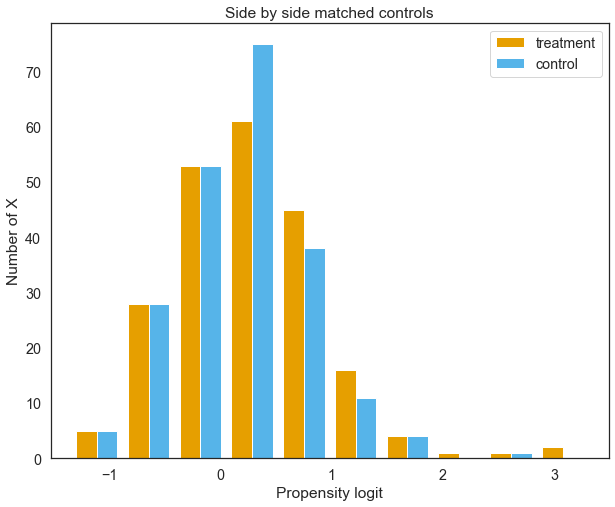

In [45]:
psm.plot_match(Title= 'Side by side matched controls', \
               Ylabel= 'Number of X', Xlabel= 'Propensity logit', names= ['treatment', 'control'], save= False)

In [44]:
psm.effect_size

,Variable,matching,Effect Size
0,prom_length,before,0.328313
1,prom_length,after,0.252948
2,price,before,0.233573
3,price,after,0.004023
4,discount_pct,before,0.035411
5,discount_pct,after,0.299737
6,coupon_duration,before,0.282300
7,coupon_duration,after,0.015672
8,featured,before,0.119074
9,featured,after,0.080893


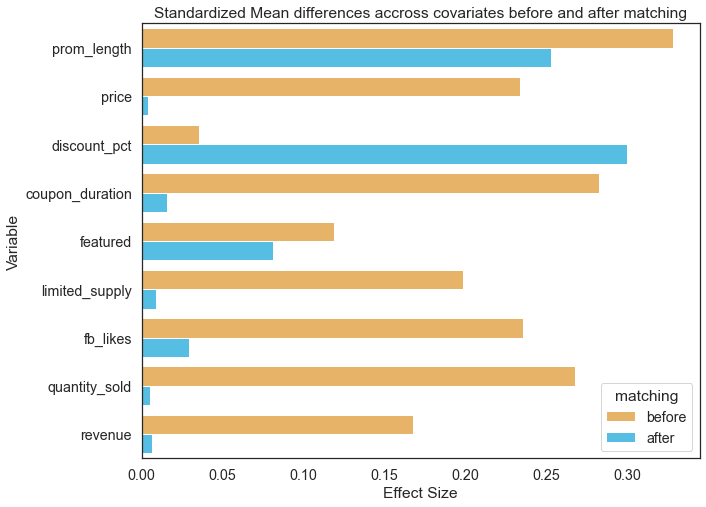

In [38]:
psm.effect_size_plot(save= False)

In [41]:
len(psm.df_matched)

431

In [42]:
gpn_matched = psm.df_matched

In [43]:
psm.matched_ids

,deal_id,matched_ID
0,heli-flights,the-butterfly-place-boston
1,gl-champion-series-tennis-electric-factory,gymboree-play-music-7
2,realm-of-terror-horror-experience,museum-city-new-york
3,newport-gourmet,gt-dream-cars-new-york
4,the-clayroom,us-rafting-2
...,...,...
211,gl-windy-city-circus-1,gl-north-plan-theater-wit
212,lets-go-paragliding,calvo-studio-1
213,spare-time-chicago-3,national-vietnam-veterans-art-museum
214,dc-gmt-slice-chicago-tours,gl-riverfront-theatre-chicago
